#***SISTEMAS DE RECOMENDACIÓN - ANÁLISIS DE FAIRNESS***
##***Trabajo Práctico - Cursada 2025***
###*Integrantes: Camila Ferreras y Enzo Daniel Heredia*
<br>



**Objetivo**

Este notebook tiene como objetivo analizar la equidad algorítmica (fairness) en el desempeño de distintos sistemas de recomendación, utilizando el dataset MovieLens 1M como caso de estudio.
<br>
<br>
**Enfoque del análisis**

El análisis se centra en evaluar si los modelos presentan diferencias de rendimiento entre diversos grupos de usuarios, considerando tanto variables demográficas (edad y género) como comportamentales (historial de interacciones, tipo de contenido preferido y género cinematográfico dominante).
<br>
<br>
**Modelos evaluados**

Los algoritmos evaluados son:
- KNNBasic, correspondiente a un enfoque de filtrado colaborativo basado en usuarios.
- SVD, basado en técnicas de factorización matricial.
<br>

**Métricas y evaluación**

Además de medir el desempeño mediante métricas tradicionales de predicción, como el RMSE, se incorporan métricas de recomendación Top-N (precisión y recall) con el fin de evaluar la calidad real de las sugerencias generadas desde la perspectiva del usuario.
<br>
<br>
**Pruebas estadísticas**

Finalmente, se aplican pruebas estadísticas (t-test y ANOVA) para determinar si las diferencias observadas entre grupos son estadísticamente significativas, permitiendo complementar la evaluación técnica con un análisis de equidad y posibles sesgos en los modelos.

#**INSTALACIÓN E IMPORTS**

In [ ]:
#Instalaciones
!pip install surprise==0.1 numpy==1.26.2

In [ ]:
#Bloque de imports generales para el proyecto.
import re
from collections import defaultdict

import numpy as np
import pandas as pd

from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split

from scipy.stats import ttest_ind, f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

#**BLOQUE 1 — Carga y preparacion del dataset.**

Este bloque une los tres componentes del dataset MovieLens 1M (usuarios, ratings y películas). Se utiliza el separador **::** y el motor **python** porque los archivos **.dat** están delimitados por **::** (no por comas estándar). Los archivos se cargan desde Google Drive convirtiendo los links de “view” a links de descarga directa.

El resultado (**df**) será nuestra base para todos los agrupamientos. Este DataFrame consolidado se utilizará para definir los grupos de usuarios y para entrenar y evaluar los algoritmos de recomendación.


In [ ]:
# Carga de archivos .dat (MovieLens 1M)
def drive_view_to_direct(url: str) -> str:
    file_id = re.search(r"/d/([^/]+)", url).group(1)
    return f"https://drive.google.com/uc?export=download&id={file_id}"

url_movies_view  = "https://drive.google.com/file/d/1Vi0_fy55WBIrJTAehvu7nDIH6nNJ8WhR/view?usp=sharing"
url_users_view   = "https://drive.google.com/file/d/1saJD1TRJp944TSBcJs4q4k46-hhicNKQ/view?usp=sharing"
url_ratings_view = "https://drive.google.com/file/d/1ccAjz-zMGDlT3bV80F0tmTSycEb_M14i/view?usp=sharing"

url_movies  = drive_view_to_direct(url_movies_view)
url_users   = drive_view_to_direct(url_users_view)
url_ratings = drive_view_to_direct(url_ratings_view)

ratings = pd.read_csv(url_ratings, sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

users = pd.read_csv(url_users, sep="::", engine="python",
                    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

movies = pd.read_csv(url_movies, sep="::", engine="python",
                     names=["MovieID", "Title", "Genres"], encoding="latin-1")

df = ratings.merge(users, on="UserID").merge(movies, on="MovieID")
df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


#**BLOQUE 2 — Agrupamientos demográficos y de comportamiento**

En este bloque se definieron los criterios de segmentación de usuarios. Inclyendo los grupos demográficos (género y edad) y los comportamentales, basados en historial, contenido y género cinematográfico dominante.

In [ ]:
# 1. Agrupamiento demográfico: Edad ---
def categorize_age(age_code):
    age_map = {
        1: 'Under18',
        18: '18-24',
        25: '25-34',
        35: '35-44',
        45: '45-49',
        50: '50-55',
        56: '56+'
    }
    return age_map.get(age_code, 'Unknown')

df['AgeGroup'] = df['Age'].apply(categorize_age)

# 2. Agrupamiento comportamental: Historial de interacciones ---
# Contamos cuántas películas calificó cada usuario
user_activity = df.groupby('UserID').size().reset_index(name='NumRatings')

# Dividimos en dos grupos según la mediana
median_interactions = user_activity['NumRatings'].median()
user_activity['HistoryLength'] = np.where(
    user_activity['NumRatings'] >= median_interactions, 'Long', 'Short'
)

# Merge con la tabla principal
df = pd.merge(df, user_activity[['UserID', 'HistoryLength']], on='UserID')

# 3. Popularidad de las películas ---
movie_popularity = df.groupby('MovieID').size().reset_index(name='MoviePopularity')
df = pd.merge(df, movie_popularity, on='MovieID')

# 4. Preferencia de contenido: popular vs nicho ---
user_popularity = df.groupby('UserID')['MoviePopularity'].mean().reset_index(name='AvgPopularity')
median_popularity = user_popularity['AvgPopularity'].median()
user_popularity['ContentPreference'] = np.where(
    user_popularity['AvgPopularity'] >= median_popularity, 'Popular', 'Niche'
)
df = pd.merge(df, user_popularity[['UserID', 'ContentPreference']], on='UserID')

# 5. Género cinematográfico dominante
def main_genre(genres):
    return genres.split('|')[0] if isinstance(genres, str) else np.nan

df['MainGenre'] = df['Genres'].apply(main_genre)

user_genre = df.groupby(['UserID', 'MainGenre']).size().reset_index(name='Count')
user_main_genre = user_genre.loc[user_genre.groupby('UserID')['Count'].idxmax()]
user_main_genre = user_main_genre[['UserID', 'MainGenre']].rename(columns={'MainGenre': 'GenrePreference'})

df = pd.merge(df, user_main_genre, on='UserID', how='left')

# Verificación
print("Distribución de usuarios por tipo de historial:")
print(user_activity['HistoryLength'].value_counts(), "\n")

print("Distribución de usuarios por tipo de preferencia de contenido:")
print(user_popularity['ContentPreference'].value_counts(), "\n")

print("Distribución de usuarios por género cinematográfico dominante:")
print(user_main_genre['GenrePreference'].value_counts().head(10))


Distribución de usuarios por tipo de historial:
HistoryLength
Long     3021
Short    3019
Name: count, dtype: int64 

Distribución de usuarios por tipo de preferencia de contenido:
ContentPreference
Popular    3020
Niche      3020
Name: count, dtype: int64 

Distribución de usuarios por género cinematográfico dominante:
GenrePreference
Comedy         2220
Action         2155
Drama          1410
Horror          108
Animation        75
Crime            28
Film-Noir        11
Adventure         9
Documentary       7
Children's        5
Name: count, dtype: int64


**Justificación de los agrupamientos**

- **Edad (AgeGroup):** se agrupó según las categorías que define MovieLens (es un estándar). Esto permite comparar resultados entre rangos etarios homogéneos y consistentes con la codificación original del dataset.

- **Historial (HistoryLength):** se usó la mediana de cantidad de ratings por usuario como punto de corte.  
  → Los usuarios por encima o igual a la mediana son “Long” (alta actividad) y los de abajo “Short” (poca actividad).  
  Este criterio tiende a generar grupos de tamaño similar, lo que facilita comparaciones justas entre segmentos.

- **Popularidad / Preferencia de contenido (ContentPreference):** se calculó el promedio de la popularidad de las películas vistas por cada usuario (donde la popularidad se aproxima por la cantidad de ratings que recibe cada película) para distinguir entre consumidores de nicho y de contenido mainstream. El corte por mediana generó grupos perfectamente balanceados, evitando que un grupo domine la muestra y mejorando la comparabilidad de las métricas.

- **Género dominante (GenrePreference):** se detectó cuál es el género más frecuente en el historial de cada usuario, para analizar posibles sesgos culturales o diferencias sistemáticas del desempeño según preferencias. Los tres géneros principales (Comedia, Acción y Drama) cubren casi el 90% de los usuarios, por lo que se espera que las estimaciones para estos grupos sean más estables.

Los géneros minoritarios presentaron muy pocos usuarios, lo que puede generar resultados estadísticos poco robustos (t-test o ANOVA con grupos desbalanceados dan resultados poco confiables). Por este motivo, se priorizaron los géneros con mayor representación. Además, en este bloque se imprimen distribuciones para verificar el balance de los agrupamientos generados (historial y preferencia de contenido) y la concentración en los géneros dominantes.


#**BLOQUE 3 — Entrenamiento de los algoritmos (KNN y SVD)**

En este bloque se implementaron los dos algoritmos seleccionados usando la librería Surprise.
Ambos se entrenan sobre el mismo conjunto de entrenamiento y se evalúan sobre el mismo test, garantizando condiciones comparables.

In [ ]:
# Preparamos los datos para Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

# División train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# MODELO 1: KNN (Filtrado colaborativo basado en usuarios)
sim_options = {'name': 'cosine', 'user_based': True}
knn_algo = KNNBasic(sim_options=sim_options)
knn_algo.fit(trainset)
knn_predictions = knn_algo.test(testset)
knn_rmse = accuracy.rmse(knn_predictions)

# MODELO 2: SVD (Factorización de matrices)
svd_algo = SVD()
svd_algo.fit(trainset)
svd_predictions = svd_algo.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)

# Mostramos resultados globales
print(f"\nRMSE KNN: {knn_rmse:.4f}")
print(f"RMSE SVD: {svd_rmse:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765
RMSE: 0.8746

RMSE KNN: 0.9765
RMSE SVD: 0.8746


El SVD supera al KNN en precisión (menor RMSE), lo que confirma una mejor capacidad de generalización en este conjunto de prueba. Esto es esperable en MovieLens, ya que los enfoques de factorización matricial suelen capturar mejor los patrones de preferencias que un método basado únicamente en similitud entre usuarios.

En el caso del modelo SVD, se utilizan los parámetros por defecto de la librería Surprise, los cuales han demostrado un buen desempeño general en el dataset MovieLens. Para KNNBasic, se configuró una similitud coseno y un enfoque user-based, consistente con el filtrado colaborativo clásico basado en usuarios.

Dado que el objetivo del trabajo es comparar modelos y analizar equidad, no se realizó un ajuste fino de hiperparámetros. Esto evita introducir sesgos por optimización desigual entre modelos y mantiene condiciones controladas: ambos modelos se entrenan y evalúan sobre la misma partición train/test (con random_state=42).

En los bloques siguientes, estas predicciones globales se desagregan por grupos demográficos y comportamentales para observar si la mejora promedio del SVD se mantiene de forma uniforme o si existen diferencias de rendimiento entre segmentos de usuarios.


#**BLOQUE 4 — Evaluación de métricas por grupo y calidad de las recomendaciones.**

En este bloque se evaluaron el rendimiento y la equidad de los modelos de recomendación según distintos criterios de agrupamiento: género, edad, historial de interacción, preferencia de contenido y género cinematográfico dominante.

A diferencia del RMSE global, se analizó si el desempeño de los modelos varió entre los distintos grupos de usuarios. Además, se incorporaron métricas de recomendación real (Top-N), junto con métricas de cobertura y diversidad, con el objetivo de obtener una evaluación más completa del sistema.

Se calcularon los valores de RMSE (Root Mean Squared Error) de forma separada por grupo demográfico y de comportamiento, con el propósito de analizar la equidad del sistema de recomendación. Para ello, se definieron los diccionarios rmse_grupal_knn y rmse_grupal_svd, los cuales almacenaron los errores promedio por categoría (género, edad, historial de interacción, preferencia de contenido y género cinematográfico dominante).

In [ ]:
# 1. Preparación del DataFrame de predicciones
def pred_to_df(predictions, df_original):
    df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    df_pred.rename(columns={
        'uid': 'UserID',
        'iid': 'MovieID',
        'r_ui': 'TrueRating',
        'est': 'EstimatedRating'
    }, inplace=True)

    user_info = df_original[
        ['UserID', 'MovieID',
         'Gender', 'AgeGroup',
         'HistoryLength', 'ContentPreference',
         'GenrePreference']
    ].drop_duplicates()

    return pd.merge(df_pred, user_info, on=['UserID', 'MovieID'], how='left')

knn_pred_df = pred_to_df(knn_predictions, df)
svd_pred_df = pred_to_df(svd_predictions, df)

# 2. RMSE por Grupo
def rmse_por_grupo(df_pred, columna_grupo):
    resultados = {}
    for grupo in df_pred[columna_grupo].dropna().unique():
        subset = df_pred[df_pred[columna_grupo] == grupo]
        rmse = np.sqrt(np.mean((subset['TrueRating'] - subset['EstimatedRating'])**2))
        resultados[grupo] = rmse
    return resultados

rmse_grupal_knn = {
    'Género': rmse_por_grupo(knn_pred_df, 'Gender'),
    'Edad': rmse_por_grupo(knn_pred_df, 'AgeGroup'),
    'Historial': rmse_por_grupo(knn_pred_df, 'HistoryLength'),
    'Preferencia': rmse_por_grupo(knn_pred_df, 'ContentPreference'),
    'Género Película': rmse_por_grupo(knn_pred_df, 'GenrePreference')
}

rmse_grupal_svd = {
    'Género': rmse_por_grupo(svd_pred_df, 'Gender'),
    'Edad': rmse_por_grupo(svd_pred_df, 'AgeGroup'),
    'Historial': rmse_por_grupo(svd_pred_df, 'HistoryLength'),
    'Preferencia': rmse_por_grupo(svd_pred_df, 'ContentPreference'),
    'Género Película': rmse_por_grupo(svd_pred_df, 'GenrePreference')
}

# IMPRESIÓN CON 3 DECIMALES (legible)
def fmt_dict(d, decimals=3):
    return {k: round(float(v), decimals) if v is not None else None for k, v in d.items()}

print("RMSE por grupo (KNN):")
for k, v in rmse_grupal_knn.items():
    print(f"{k}: {fmt_dict(v, 3)}")

print("\nRMSE por grupo (SVD):")
for k, v in rmse_grupal_svd.items():
    print(f"{k}: {fmt_dict(v, 3)}")

# 3. Métricas de Recomendación: Precisión@N y Recall@N
def get_top_n(predictions, n=10, min_rating=4.0):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if est >= min_rating:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def precision_recall_at_n(predictions, n=10, threshold=4.0):
    top_n = get_top_n(predictions, n=n, min_rating=threshold)
    precisions, recalls = [], []

    for uid, user_ratings in top_n.items():
        true_items = [iid for (uid_p, iid, true_r, est, _) in predictions
                      if uid_p == uid and true_r >= threshold]
        recommended_items = [iid for (iid, _) in user_ratings]

        n_hit = len(set(true_items).intersection(set(recommended_items)))
        precision = n_hit / len(recommended_items) if recommended_items else 0
        recall = n_hit / len(true_items) if true_items else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

precision_knn, recall_knn = precision_recall_at_n(knn_predictions, n=10)
precision_svd, recall_svd = precision_recall_at_n(svd_predictions, n=10)

print("\nPrecisión y Recall (Top-10):")
print(f"KNN → Precisión@10 = {precision_knn:.3f}, Recall@10 = {recall_knn:.3f}")
print(f"SVD → Precisión@10 = {precision_svd:.3f}, Recall@10 = {recall_svd:.3f}")

# 4. Cobertura y Diversidad
def coverage(predictions, total_items):
    recommended_items = set([iid for (_, iid, _, _, _) in predictions])
    return len(recommended_items) / total_items

def diversity(predictions, df_movies):
    recommended_items = list(set([iid for (_, iid, _, _, _) in predictions]))
    genres = df_movies[df_movies['MovieID'].isin(recommended_items)]['Genres']
    unique_genres = set(g for sublist in genres.str.split('|').dropna() for g in sublist)
    return len(unique_genres)

total_movies = df['MovieID'].nunique()
div_knn = diversity(knn_predictions, movies)
div_svd = diversity(svd_predictions, movies)
cov_knn = coverage(knn_predictions, total_movies)
cov_svd = coverage(svd_predictions, total_movies)

print("\n🔹 Cobertura y Diversidad:")
print(f"KNN → Cobertura: {cov_knn:.3f}, Diversidad: {div_knn}")
print(f"SVD → Cobertura: {cov_svd:.3f}, Diversidad: {div_svd}")


RMSE por grupo (KNN):
Género: {'M': 0.971, 'F': 0.995}
Edad: {'18-24': 1.018, '56+': 0.962, '25-34': 0.975, '50-55': 0.945, '35-44': 0.954, '45-49': 0.943, 'Under18': 1.08}
Historial: {'Long': 0.972, 'Short': 1.002}
Preferencia: {'Niche': 0.989, 'Popular': 0.94}
Género Película: {'Comedy': 0.982, 'Action': 0.969, 'Drama': 0.957, 'Horror': 1.172, 'Crime': 0.994, 'Animation': 1.201, "Children's": 1.219, 'Film-Noir': 1.196, 'Western': 0.817, 'Documentary': 0.987, 'Adventure': 1.067, 'Musical': 1.006, 'Mystery': 0.778, 'Sci-Fi': 0.984}

RMSE por grupo (SVD):
Género: {'M': 0.864, 'F': 0.905}
Edad: {'18-24': 0.906, '56+': 0.874, '25-34': 0.871, '50-55': 0.855, '35-44': 0.858, '45-49': 0.844, 'Under18': 0.965}
Historial: {'Long': 0.865, 'Short': 0.931}
Preferencia: {'Niche': 0.877, 'Popular': 0.866}
Género Película: {'Comedy': 0.883, 'Action': 0.86, 'Drama': 0.861, 'Horror': 1.07, 'Crime': 0.934, 'Animation': 1.013, "Children's": 1.096, 'Film-Noir': 1.085, 'Western': 0.742, 'Documentary': 0.9

**RMSE por grupo**

Esta métrica permitió observar si el modelo predijo con diferente nivel de precisión según el grupo analizado, por ejemplo, si presentó menor error en usuarios de un determinado género o en quienes consumen ciertos tipos de contenido. En este sentido, el RMSE por grupo constituyó una medida directa de equidad algorítmica (fairness).

**Métricas Top-N: Precisión y Recall**

Las métricas de Precisión@N y Recall@N evaluaron la calidad de las recomendaciones reales, más allá de la exactitud en la predicción de los ratings.

Precisión@N midió cuántas de las N películas recomendadas fueron realmente valoradas positivamente por el usuario.

Recall@N midió cuántas de las películas valoradas positivamente por el usuario fueron efectivamente recomendadas por el sistema.

Estas métricas permitieron analizar la utilidad real del sistema de recomendación desde la perspectiva del usuario.

**Cobertura y diversidad**

La cobertura midió la proporción del catálogo total que el sistema logró recomendar. Un valor bajo de cobertura puede indicar un sesgo hacia un conjunto reducido de ítems, generalmente los más populares.

La diversidad midió la variedad de géneros presentes en las recomendaciones, evaluando si el modelo exploró distintos tipos de contenido o se concentró en un número limitado de géneros.

Ambas métricas resultaron fundamentales para analizar el equilibrio entre precisión y pluralidad, dado que un sistema de recomendación justo no solo debe ser preciso, sino también ofrecer recomendaciones variadas y representativas del catálogo disponible.

#**BLOQUE 5 — Tests Estadísticos y Análisis de Fairness**

**Tests estadísticos**

Los valores de p permitieron evaluar la existencia de diferencias estadísticamente significativas en los errores de predicción (RMSE) entre los distintos grupos analizados.

En ambos modelos (KNN y SVD), se obtuvieron valores de p inferiores a 0.05, lo que indicó la presencia de diferencias estadísticamente significativas en el rendimiento del sistema según el grupo considerado.

Estas diferencias se observaron en variables como género, edad, historial de interacción y preferencia de contenido.

En el caso del modelo SVD, la diferencia asociada a la variable Preferencia de contenido (p = 0.00113) resultó menos marcada que en el modelo KNN, lo que evidenció un comportamiento ligeramente más equilibrado en ese aspecto.

En términos generales, el modelo SVD presentó menores diferencias de error entre grupos, lo que reflejó un mejor desempeño desde la perspectiva de equidad algorítmica (fairness).

| Métrica          | KNN    | SVD    | Interpretación                                                      |
| ---------------- | ------ | ------ | ------------------------------------------------------------------- |
| **RMSE global**  | 0.9765 | 0.8737 | SVD predice ratings con menor error promedio.                       |
| **Precision@10** | 0.806  | 0.856  | SVD recomienda películas más relevantes.                            |
| **Recall@10**    | 0.396  | 0.400  | Ambos cubren similar proporción de películas relevantes.            |
| **Cobertura**    | 0.937  | 0.937  | Ambos cubren la misma cantidad de ítems del catálogo.               |
| **Diversidad**   | 18     | 18     | Ambos muestran un rango de variedad similar en las recomendaciones. |

**Conclusión comparativa:**

En conjunto, el modelo SVD superó al KNN en términos de precisión, estabilidad entre grupos y calidad global de las recomendaciones, lo que lo posicionó como una alternativa más adecuada para sistemas que priorizan la personalización y la equidad.

**Fairness y sesgos**

El modelo KNN, basado en filtrado colaborativo por similitud entre usuarios, tendió a amplificar los sesgos presentes en los datos originales. Al apoyarse en patrones de comportamiento dominantes, el sistema favoreció a los grupos mayoritarios, lo que pudo generar recomendaciones desbalanceadas en términos de género, preferencias o nivel de actividad de los usuarios.

Por el contrario, el modelo SVD, mediante la factorización de matrices, descompuso la información en factores latentes que representaron características implícitas de usuarios y películas. Este enfoque permitió suavizar los sesgos de representación y mejorar la generalización hacia usuarios menos activos o con preferencias alejadas del promedio.

Como resultado, el SVD logró un mejor equilibrio entre precisión y equidad, reduciendo las diferencias de rendimiento entre los distintos grupos analizados.

 Tests estadísticos — KNN
  Gender: p-value = 0.00000
  AgeGroup: p-value = 0.00000
  HistoryLength: p-value = 0.00000
  ContentPreference: p-value = 0.00000
  GenrePreference: p-value = 0.00000

 Tests estadísticos — SVD
  Gender: p-value = 0.00000
  AgeGroup: p-value = 0.00000
  HistoryLength: p-value = 0.00000
  ContentPreference: p-value = 0.00168
  GenrePreference: p-value = 0.00000


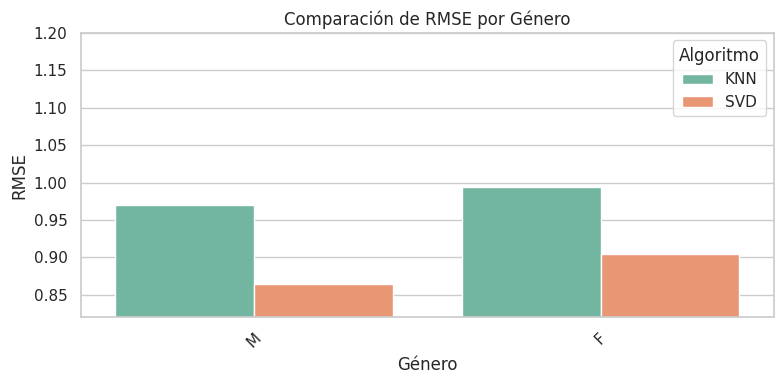

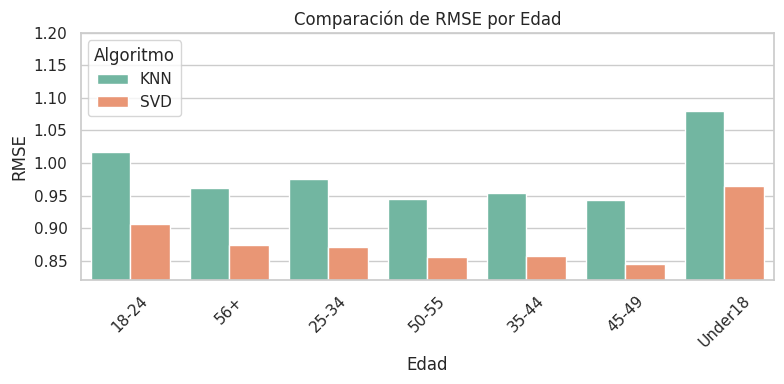

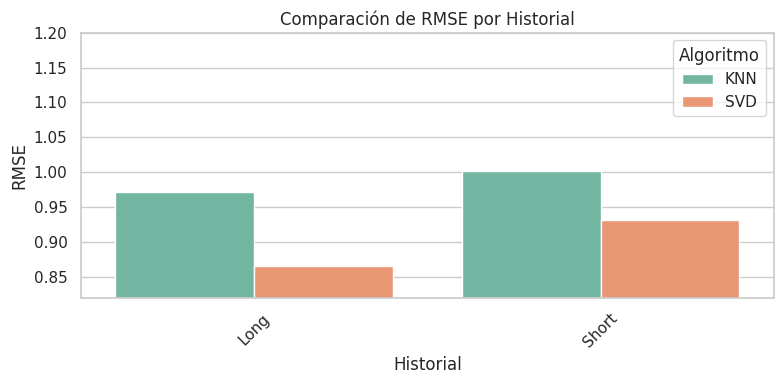

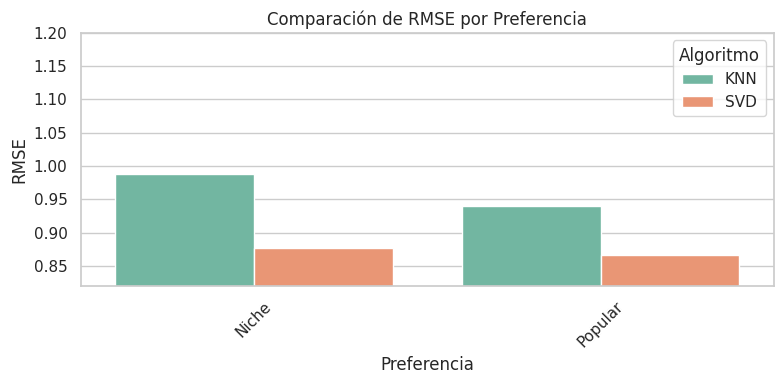

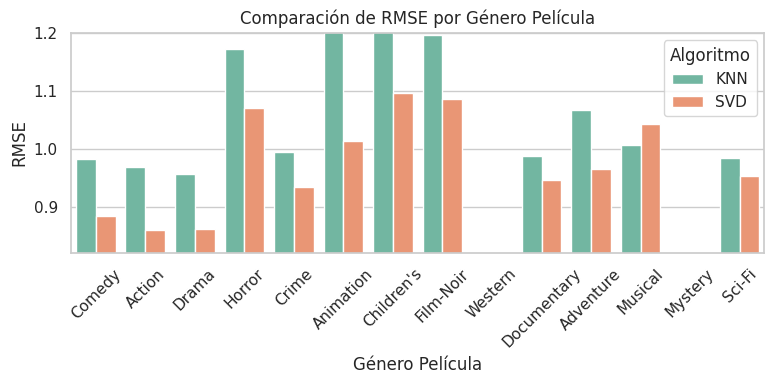

In [ ]:
# 1. Función general de test estadístico
def calcular_ttest(df, variable):
    """
    Si hay dos grupos → T-test
    Si hay más de dos → ANOVA
    """
    grupos = df[variable].dropna().unique()
    if len(grupos) == 2:
        g1, g2 = grupos
        e1 = abs(df[df[variable] == g1]['TrueRating'] - df[df[variable] == g1]['EstimatedRating'])
        e2 = abs(df[df[variable] == g2]['TrueRating'] - df[df[variable] == g2]['EstimatedRating'])
        _, p_val = ttest_ind(e1, e2, equal_var=False)
    else:
        errores = [abs(df[df[variable] == g]['TrueRating'] - df[df[variable] == g]['EstimatedRating']) for g in grupos]
        _, p_val = f_oneway(*errores)
    return p_val

variables = ['Gender', 'AgeGroup', 'HistoryLength', 'ContentPreference', 'GenrePreference']

# 2. Ejecutar los tests para ambos modelos
print(" Tests estadísticos — KNN")
p_knn = {v: calcular_ttest(knn_pred_df, v) for v in variables}
for k, v in p_knn.items():
    print(f"  {k}: p-value = {v:.5f}")

print("\n Tests estadísticos — SVD")
p_svd = {v: calcular_ttest(svd_pred_df, v) for v in variables}
for k, v in p_svd.items():
    print(f"  {k}: p-value = {v:.5f}")

# 3. Interpretación
"""
Valores de p inferiores a 0.05 indicaron la existencia de diferencias
estadísticamente significativas en el error de predicción entre los distintos
grupos analizados.

Estos resultados evidenciaron que el desempeño del modelo no fue homogéneo
entre grupos, lo cual puede interpretarse como una señal de posible
sesgo algorítmico.
"""

# 4. Gráficos comparativos de RMSE (por grupo)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

def graficar_comparacion(categoria, datos_knn, datos_svd):
    df_plot = []
    for grupo, val_knn in datos_knn.items():
        val_svd = datos_svd.get(grupo, None)
        df_plot.append({'Grupo': grupo, 'Algoritmo': 'KNN', 'RMSE': val_knn})
        if val_svd is not None:
            df_plot.append({'Grupo': grupo, 'Algoritmo': 'SVD', 'RMSE': val_svd})

    df_plot = pd.DataFrame(df_plot)
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_plot, x='Grupo', y='RMSE', hue='Algoritmo', palette='Set2')
    plt.title(f'Comparación de RMSE por {categoria}')
    plt.xlabel(categoria)
    plt.ylabel('RMSE')
    plt.ylim(0.82, 1.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for categoria in rmse_grupal_knn.keys():
    graficar_comparacion(categoria, rmse_grupal_knn[categoria], rmse_grupal_svd[categoria])


#**BLOQUE 6 - Síntesis de resultados y conclusiones finales**

Los resultados obtenidos mostraron que ambos algoritmos presentaron diferencias estadísticamente significativas en su desempeño entre distintos grupos demográficos y de comportamiento. No obstante, el modelo SVD logró reducir parcialmente dichas disparidades, evidenciando una mayor capacidad para capturar las preferencias reales de los usuarios de manera más uniforme.

Las métricas de precisión y recall confirmaron que el SVD ofreció recomendaciones más relevantes, sin sacrificar cobertura ni diversidad en comparación con el modelo KNN.

Desde la perspectiva de equidad algorítmica (fairness), estos resultados indicaron que el modelo SVD fue más robusto frente a sesgos de popularidad y comportamiento. Por este motivo, se presentó como una opción más adecuada para entornos en los que la diversidad de usuarios y contenidos constituye un objetivo central del sistema de recomendación.

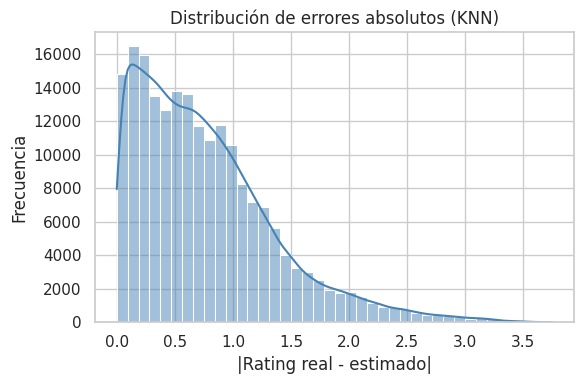

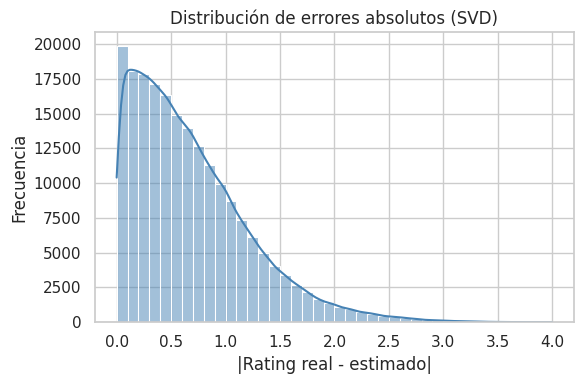

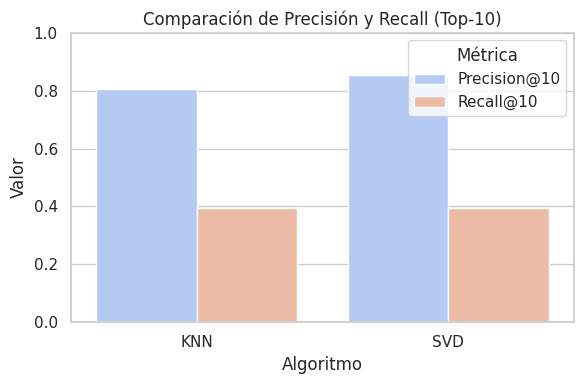

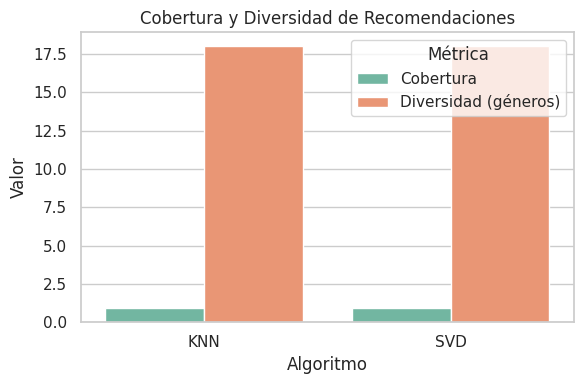

In [ ]:
# 1. Distribución de errores (equidad visual)
def graficar_errores(pred_df, modelo_name):
    pred_df['Error'] = abs(pred_df['TrueRating'] - pred_df['EstimatedRating'])
    plt.figure(figsize=(6, 4))
    sns.histplot(pred_df['Error'], bins=40, color='steelblue', kde=True)
    plt.title(f"Distribución de errores absolutos ({modelo_name})")
    plt.xlabel("|Rating real - estimado|")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

graficar_errores(knn_pred_df, "KNN")
graficar_errores(svd_pred_df, "SVD")

# 2. Comparación de Precision@10 y Recall@10
precision_recall = pd.DataFrame({
    'Algoritmo': ['KNN', 'SVD'],
    'Precision@10': [precision_knn, precision_svd],
    'Recall@10': [recall_knn, recall_svd]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=precision_recall.melt(id_vars='Algoritmo', var_name='Métrica', value_name='Valor'),
            x='Algoritmo', y='Valor', hue='Métrica', palette='coolwarm')
plt.title('Comparación de Precisión y Recall (Top-10)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 3. Análisis de diversidad y cobertura
metricas_globales = pd.DataFrame({
    'Algoritmo': ['KNN', 'SVD'],
    'Cobertura': [cov_knn, cov_svd],
    'Diversidad (géneros)': [div_knn, div_svd]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=metricas_globales.melt(id_vars='Algoritmo', var_name='Métrica', value_name='Valor'),
            x='Algoritmo', y='Valor', hue='Métrica', palette='Set2')
plt.title('Cobertura y Diversidad de Recomendaciones')
plt.tight_layout()
plt.show()


**Conclusión**

En conclusión, el modelo SVD demostró un desempeño superior al modelo KNN en términos de precisión global, calidad de las recomendaciones y estabilidad entre grupos, manteniendo además niveles adecuados de cobertura y diversidad. Estos resultados lo posicionan como una alternativa más robusta para sistemas de recomendación que buscan equilibrar rendimiento y equidad.

Asimismo, el análisis de fairness puso en evidencia que, si bien ambos algoritmos presentan diferencias estadísticamente significativas entre distintos grupos de usuarios, el SVD logra atenuar parcialmente dichas disparidades. Esto sugiere que los enfoques basados en factores latentes permiten una mejor generalización de las preferencias y reducen la amplificación de sesgos presentes en los datos originales.

De este modo, el trabajo resalta la importancia de complementar las métricas tradicionales de desempeño con evaluaciones de equidad algorítmica, reforzando la idea de que un sistema de recomendación eficaz no solo debe ser preciso, sino también justo e inclusivo.